In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re
import time
import cv2
import random
import math
from keras.datasets import mnist
import setuptools
%load_ext Cython

Using TensorFlow backend.
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym o

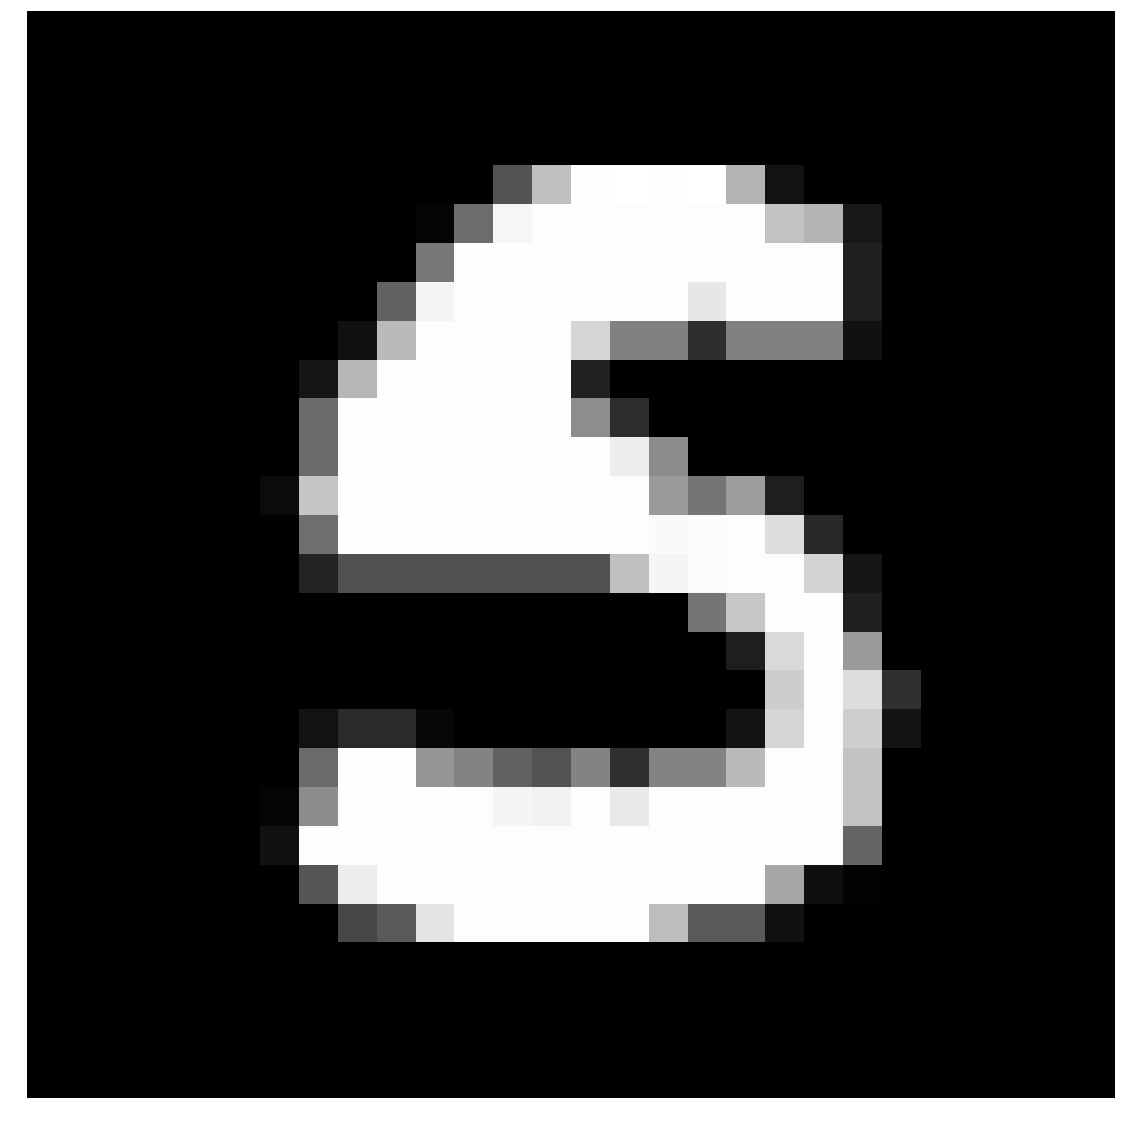

In [47]:
def disp(X):
    fig, ax=plt.subplots(1,1,figsize=(20,20))
    ax.imshow(X)
    ax.axis('off')
    plt.show()

def supdisp(X, ax=None, titel=''):
    charred_bloodbirds_escape_from_the_ruins=0
    if (ax==None):
        charred_bloodbirds_escape_from_the_ruins=1
        fig, ax=plt.subplots(1,1,figsize=(20,20))
    Y=X.copy()
    
    zz1=Y.copy()
    Y=np.append(Y, zz1, axis=2)
    Y=np.append(Y, zz1, axis=2)
    
    ax.imshow(Y)
    ax.set_title(titel)
    ax.axis('off')
    if (charred_bloodbirds_escape_from_the_ruins==1):
        plt.show()

(trainX, trainy), (testX, testy) = mnist.load_data()
zz=trainX[1997]
zz=zz.reshape(zz.shape[0], zz.shape[1], 1)
zz1=zz.copy()

zz=np.append(zz, zz1, axis=2)
zz=np.append(zz, zz1, axis=2)
zz=zz/255
disp(zz)
#print(zz.dtype, type(zz))

In [3]:
def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0

def relu_forw(v):
    return np.asmatrix(np.apply_along_axis(lambda x: max(0.0, x), 1, v).reshape(v.shape[0], 1))

def relu_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: np.sign(max(0.0, x)), 1, v).reshape(v.shape[0], 1))

def sigm_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigm_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def tanh_forw(v):
    return np.asmatrix(np.apply_along_axis(math.tanh, 1, v).reshape(v.shape[0], 1))

def tanh_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: (1+math.tanh(x))*(1-math.tanh(x)), 1, v).reshape(v.shape[0], 1))

In [49]:
#Ustawianie parametrów
#Rozdział ustawienia parametrów i neurala - pozwala mi na wznowiecie nauki neurala bez zapisu outów

#Wagi, biasy, delty wag/biasów
w=[0]*10
bw=[0]*10
weight_delta=[0]*10
bias_delta=[0]*10

#Tymczasowe zmienne do trzymania outów i pochodnych po backpropagosie
act=[0]*10
wact=[0]*10
back_p=[0]*10
#lyrning rejt
nn_delta=0.1
#Funkcje wykonywane przez warstwy, warstwy - logic (bez 1-wszej: input)[rozmiar k-tej warstwy od 1]
lst=28*28
logic=[50,20,50,lst]
fforw=[sigm_forw, sigm_forw, sigm_forw, sigm_forw]
fback=[sigm_back, sigm_back, sigm_back, sigm_back]

ll=len(logic)

#Determinacja wag i biasów
for i in range(ll):
    w[i]=np.asmatrix([0.15*np.random.normal(0, 1) for j in range(lst*logic[i])]).reshape(logic[i], lst)
    bw[i]=0.15*np.random.normal(0, 1)
    lst=logic[i]

In [54]:
#iteracje, epoki, zapis wyniku do wykresu
iterr=20000
epokz=2
aedificator_mundi_carcerem=[0]*(iterr*epokz)

for ii in range(epokz):
    t1=time.time()
    for i in range(iterr):
        img=trainX[i].copy()
        img=img/255
        img=img.reshape(img.shape[0]*img.shape[1],1)

        wact[0]=np.asmatrix(img.copy())
        for j in range(1, ll+1):
            act[j]=w[j-1]*wact[j-1]#+bw[j-1]
            wact[j]=fforw[j-1](act[j])

        ####  Kost
        kgb=np.asarray(img)-np.asarray(wact[ll])
        der=-2*kgb
        kgb=kgb*kgb
        s=(sum(kgb)/len(kgb))
        s=s[0]
        aedificator_mundi_carcerem[iterr*ii+i]=s
        ####

        #kar=np.asarray(wact[ll]).reshape(trainX[i].shape[0], trainX[i].shape[1], 1)
        #supdisp(kar)

        back_p[ll+1]=der    
        for j in range(ll,0,-1):
            sdel=np.multiply(fback[j-1](act[j]),back_p[j+1])
            weight_delta[j-1]=sdel*wact[j-1].T
            #bias_delta[j-1]=sum(sdel)[0,0]/len(sdel)
            back_p[j]=w[j-1].T*sdel

        for j in range(ll):
            w[j]-=weight_delta[j]*nn_delta
            #bw[j]-=bias_delta[j]*nn_delta
    t2=time.time()
    print(t2-t1)

321.7164011001587
320.183313369751


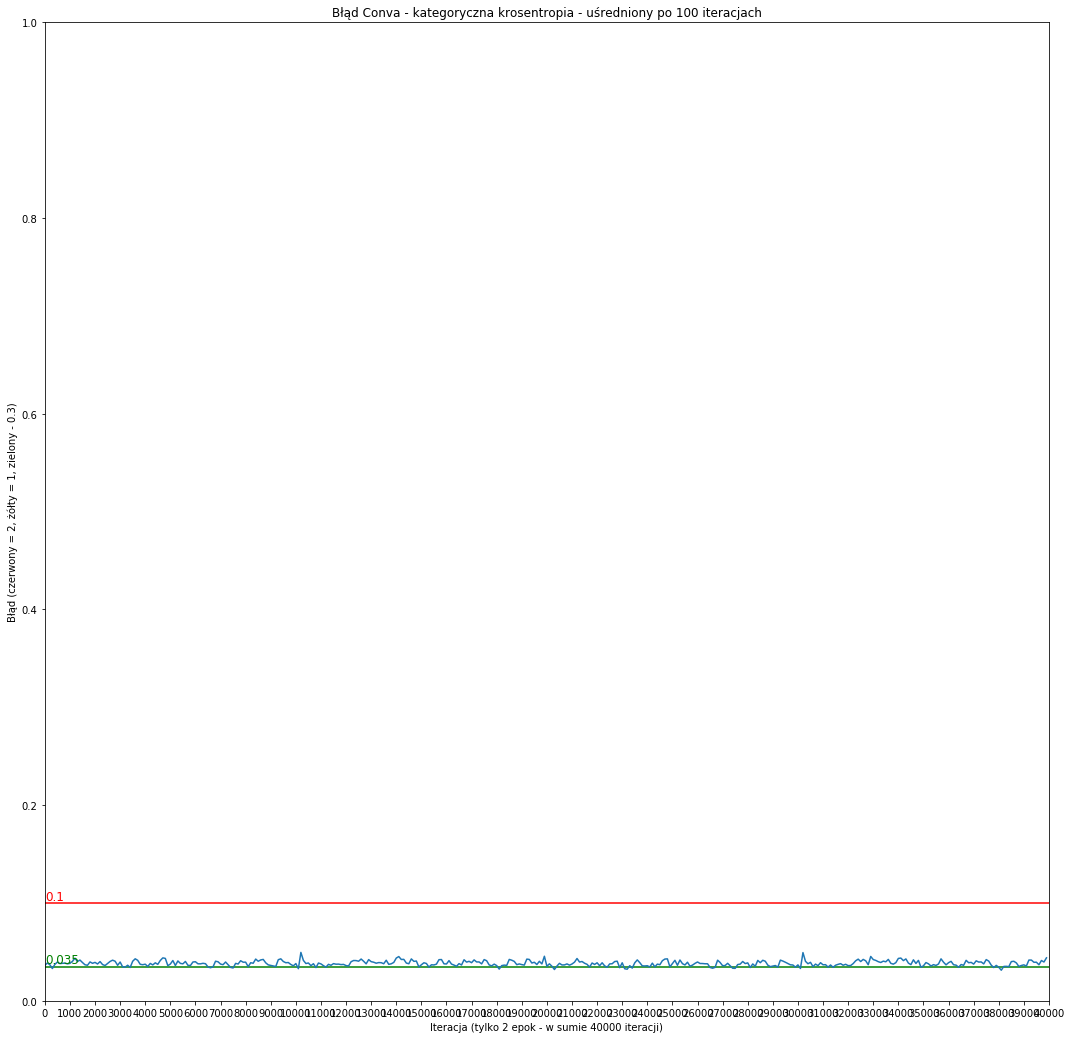

In [55]:
fig, ax=plt.subplots(1, 1, figsize=(18,18))
#dt - liczba iteracji, kgbo - uśrednienie błędu po tylu iteracjach, ss- parametr labeli
dt=iterr*epokz
kgbo=100
dt2=dt//kgbo
ss=10

#Formulacja średnich
dkkk=[0]*dt2
for i in range(dt2):
    dkkk[i]=sum(aedificator_mundi_carcerem[i*kgbo:(i+1)*kgbo])/kgbo

ax.set_title('Błąd Conva - kategoryczna krosentropia - uśredniony po {} iteracjach'.format(kgbo))
ax.set_xlabel('Iteracja (tylko {} epok - w sumie {} iteracji)'.format(epokz, dt))
ax.set_xticklabels(range(0, dt+1, kgbo*ss))
ax.set_xticks(range(0, dt//kgbo+1, ss))
ax.set_ylabel('Błąd (czerwony = 2, żółty = 1, zielony - 0.3)')
ax.axhline(0.1, color='red')
ax.axhline(0.035, color='green')
ax.plot(dkkk)
ax.text(x=0, y=0.1, s='0.1', verticalalignment='bottom', horizontalalignment='left', color='red', size=12)
ax.text(x=0, y=0.035, s='0.035', verticalalignment='bottom', horizontalalignment='left', color='green', size=12)
ax.set_ylim(0, 1)
ax.set_xlim(-0.1, dt2)
plt.show()

In [119]:
print(aedificator_mundi_carcerem)

[0.24266537230520058, 0.2422648299314806, 0.2418658298682807, 0.24146834834652228, 0.24107236187384926, 0.240677847234222, 0.24028478148748791, 0.2398931419689261, 0.23950290628877294, 0.23911405233171584, 0.2387265582563703, 0.23834040249473282, 0.237955563751611, 0.23757202100402997, 0.23718975350061933, 0.23680874076097733, 0.23642896257501525, 0.23605039900227578, 0.23567303037124246, 0.23529683727861186, 0.23492180058856094, 0.23454790143198598, 0.23417512120572317, 0.23380344157175137, 0.23343284445637405, 0.23306331204938205, 0.23269482680319795, 0.23232737143199964, 0.23196092891082912, 0.23159548247467848, 0.23123101561755643, 0.23086751209154446, 0.23050495590582373, 0.23014333132569173, 0.22978262287155682, 0.22942281531791636, 0.22906389369231614, 0.2287058432742921, 0.2283486495942931, 0.2279922984325883, 0.22763677581815367, 0.2272820680275424, 0.2269281615837387, 0.22657504325499062, 0.22622270005362816, 0.22587111923486292, 0.2255202882955687, 0.2251701949730471, 0.2248

In [7]:
f=[None, sigm_forw, sigm_forw, sigm_forw, sigm_forw, sigm_forw]
print(f)

[None, <function sigm_forw at 0x000000001F0FEA60>, <function sigm_forw at 0x000000001F0FEA60>, <function relu_forw at 0x000000001F0FE840>]


0.82004714012146


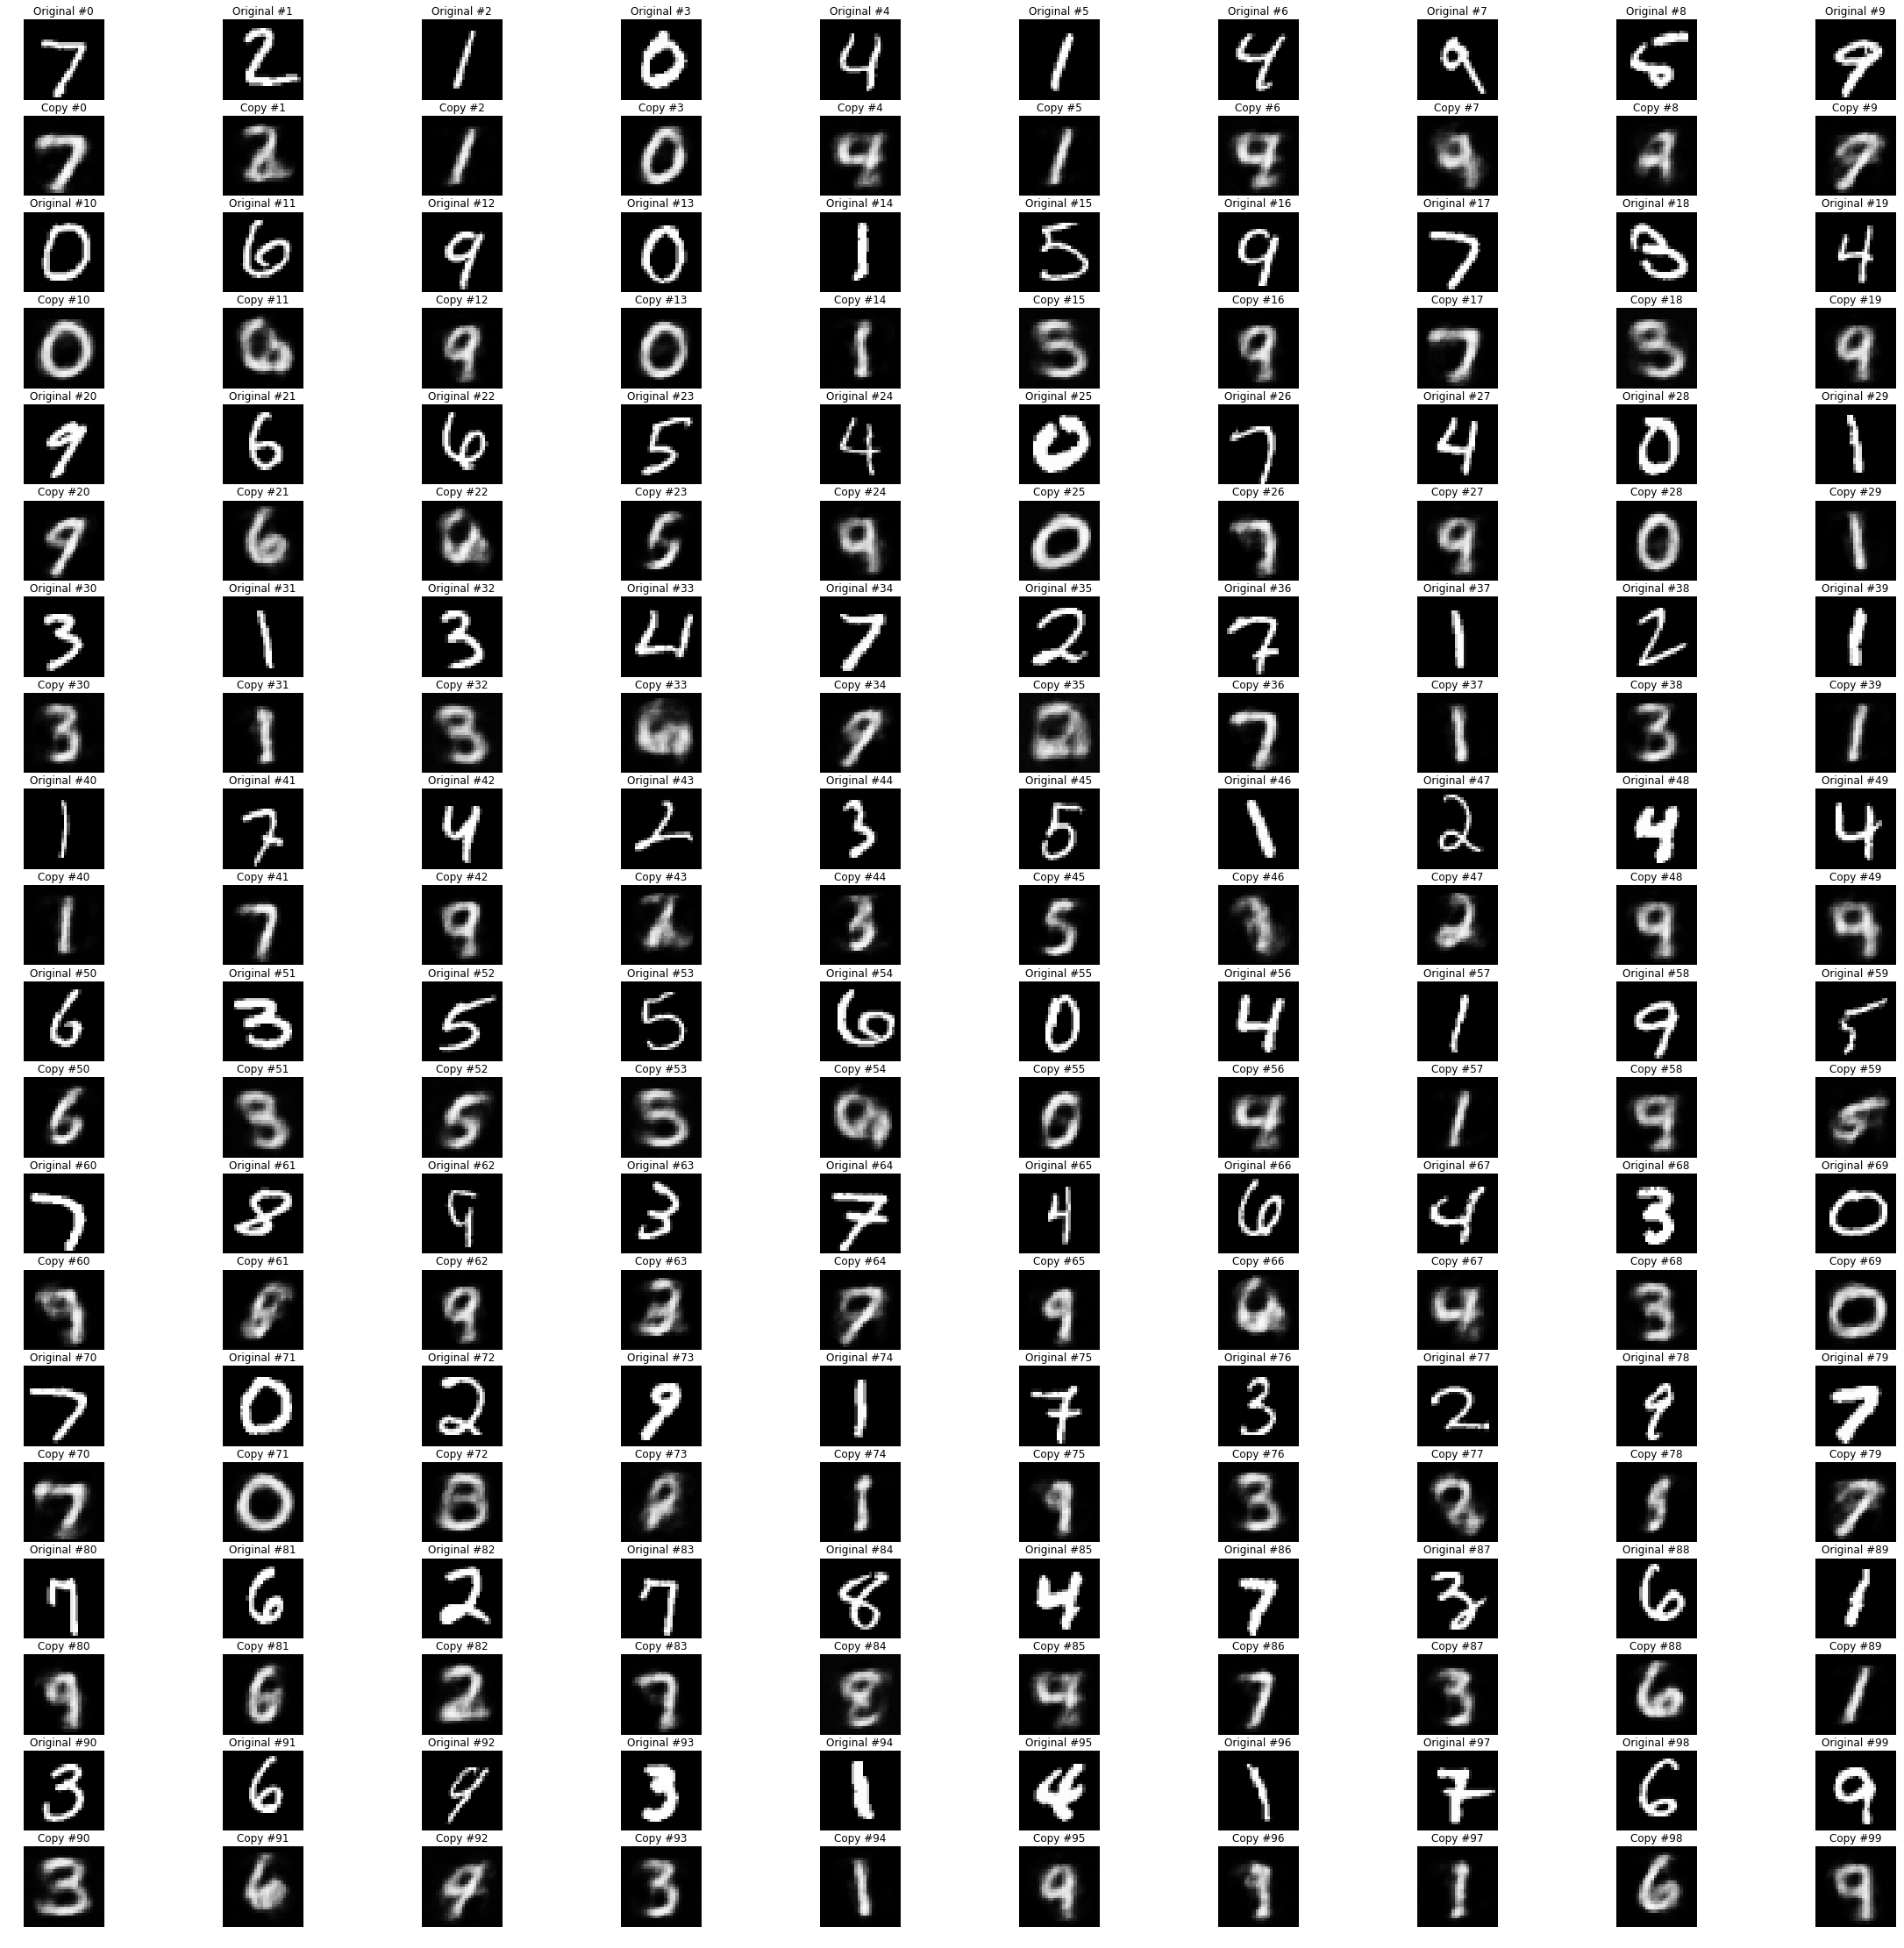

In [56]:
#Liczba obrazków z testu
iterr=100

act=[0]*10
wact=[0]*10
ggout=[0]*iterr
#Tworze
fig, ax=plt.subplots(20, 10, figsize=(40,40))

t1=time.time()
for i in range(iterr):
    img=testX[i].copy()
    img=img/255
    img=img.reshape(img.shape[0]*img.shape[1],1)

    wact[0]=np.asmatrix(img.copy())
    for j in range(1, ll+1):
        act[j]=w[j-1]*wact[j-1]#+bw[j-1]
        wact[j]=fforw[j-1](act[j])

    ####  Kost
    kgb=np.asarray(img)-np.asarray(wact[ll])
    kgb=kgb*kgb
    s=(sum(kgb)/len(kgb))
    s=s[0]
    ggout[i]=s
    ####
    
    supdisp(testX[i].reshape(testX[i].shape[0], testX[i].shape[1], 1), ax[2*(i//10)][i%10], 'Original #{}'.format(i))
    kar=np.asarray(wact[ll]).reshape(testX[i].shape[0], testX[i].shape[1], 1)
    supdisp(kar, ax[2*(i//10)+1][i%10], 'Copy #{}'.format(i))
t2=time.time()
print(t2-t1)
plt.show()

In [12]:
kkk=np.asmatrix([[0], [1], [2], [3]])
print(kkk+2)

[[2]
 [3]
 [4]
 [5]]


In [22]:
print(bias_delta)
print(sum(sdel)[0,0])

[-0.04760082662278464, 0.46436947120738, 10.82956218440274, 137.97111577949357, 0, 0, 0, 0, 0, 0]
-0.04760082662278464


In [50]:
print(math.tanh(2))

0.9640275800758169
